<a href="https://colab.research.google.com/github/Weizhuo-Zhang/ML_coursera/blob/master/hands_on_ML/3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. 分类

## MNIST

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache=False)

一般而言，由 **`sklearn`** 加载的数据集有着相似的字典结构，这包括：

- `DESCR` 键描述数据集
- `data` 键存放一个数组，数组的一行表示一个样例，一列表示一个特征
- `target` 键存放一个标签数组

**注意：**fetch_mldata已经失效了。

In [10]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [11]:
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
mnist.target

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [33]:
import numpy as np

X, y = mnist.data, mnist.target
y = y.astype(np.int8)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


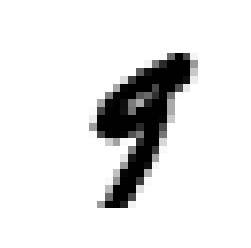

In [34]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [35]:
y[36000]

9

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [0]:
#打乱训练集
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二分类器

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

 用随机梯度下降分类器`SGD`，使用 **`Scikit-Learn`** 的
`SGDClassifier` 类。这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于`SGD`一次只处理一条数据,这也使得 `SGD` 适合在线学习(online learning)。

In [39]:
from sklearn.linear_model  import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## 对性能的评估
### 使用交叉验证测量准确性

In [44]:
# cross_val_score()
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9303
0.93265
0.96895


In [0]:
# 使用cross_val_score()来评估SGDClassifier

In [48]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9303 , 0.93265, 0.96895])

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [50]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.911  , 0.91055, 0.9074 ])

## 混淆矩阵

大体思路是:输出类别A被分类成类别 B 的次数。举个例子,为了知道分类器将 5 误分为 3 的次数,你需要查看混淆矩阵的第五行第三列。

In [0]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

就像 `cross_val_score()` , `cross_val_predict()` 也使用 K 折交叉验证。它不是返回一个评估分数,而是返回基于每一个测试折做出的一个预测值。这意味着,对于每一个训练集的样例,你得到一个干净的预测(“干净”是说一个模型在训练过程当中没有用到测试集的数据)。

现在使用测类( `confusion_matrix()` 函数,你将会得到一个混淆矩阵。传递目标类( `y_train_5` )和预测类( `y_train_pred` )给它。

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52008,  2571],
       [  791,  4630]])

$$precision = \frac {TP} {TP + FP}$$

$$recall(TPR) = \frac {TP} {TP + FN}$$

### Precision and Recall

In [62]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.6429662546868491
0.854085961999631


通常结合准确率和召回率会更加方便,这个指标叫做“F1 值”,特别是当你需要一个简单的方法去比较两个分类器的优劣的时候。F1 值是准确率和召回率的调和平均。普通的平均值平等地看待所有的值,而调和平均会给小的值更大的权重。所以,要想分类器得到一个高的 F1值,需要召回率和准确率同时高。

$$F1 = \frac {2} {\frac {1} {precision} + \frac {1} {recall}} = 2 * \frac {precision * recall} {precision + recall} = \frac {TP} {TP + \frac {FN + FP} {2}}$$

In [64]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_pred)

ValueError: ignored

### Precision/Recall之间的折中

**`Scikit-Learn`** 不让你直接设置阈值,但是它给你提供了设置决策分数的方法,这个决策分数可以用来产生预测。它不是调用分类器的 `predict()` 方法,而是调用 `decision_function()` 方法。这个方法返回每一个样例的分数值,然后基于这个分数值,使用你想要的任何阈值做出预测。

In [66]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-2960.57847601]
[False]


In [68]:
threshold = -20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

你需要再次使用 `cross_val_predict()` 得到每一个样例的分数值,但是这一次指定返回一个决策分数,而不是预测值。

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

现在有了这些分数值。对于任何可能的阈值,使用
 `precision_recall_curve()`,你都可以计算准确率和召回率:

In [0]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

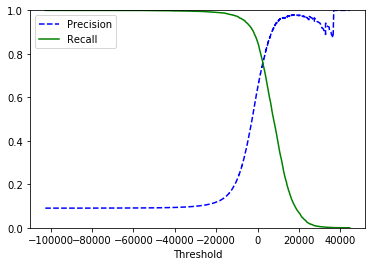

In [74]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0, 1])
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

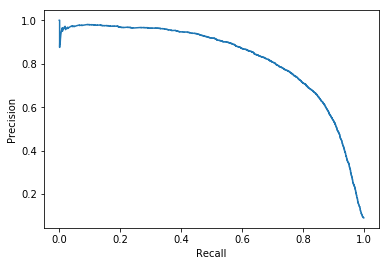

In [76]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [82]:
y_train_pred_90 = (y_scores > 7000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.90345686701962
0.5351411178749308


### ROC 曲线

ROC曲线是TPR和FPR的曲线。$FPR = 1 - TNR$

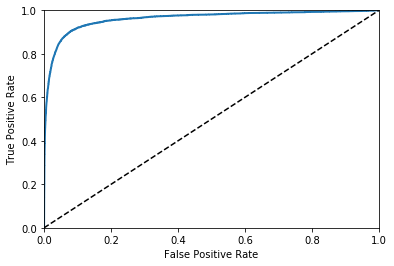

In [84]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

一个好的分类器的 ROC 曲线应该尽可能远离这条线(即向左上角方向靠拢)。

一个比较分类器之间优劣的方法是:测量ROC曲线下的面积(AUC)。一个完美的分类器的 ROC AUC 等于 1,而一个纯随机分类器的 ROC AUC 等于 0.5。Scikit-Learn 提供了一个函数来计算 ROC AUC:

In [85]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9614471807456934

优先使用 PR 曲线当正例很少,或者当你关注假正例多于假反例的时候。其他情况使用 ROC 曲线。举例子,回顾前面的 ROC 曲线和 ROC AUC 数值, 你或许认为这个分类器很棒。但是这几乎全是因为只有少数正例(“是 5”),而大部分是反例(“非 5”)。相反,PR 曲线清楚显示出这个分类器还有很大的改善空间(PR 曲线应该尽可能地靠近右上角)。

让我们训练一个 `RandomForestClassifier` ,然后拿它的的ROC曲线和ROC AUC数值去跟 `SGDClassifier`的比较。首先你需要得到训练集每个样例的数值。但是由于随机森林分类器 `RandomForestClassifier
predict_proba()
不提供
decision_function()
方法。Skikit-Learn分类器通常二者中的一个。
方法。相反,它提供
predict_proba()
方法返回
一个数组,数组的每一行代表一个样例,每一列代表一个类。数组当中的值的意思是:给定
一个样例属于给定类的概率。比如,70%的概率这幅图是数字 5。